In [1]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score
import dask_ml
import dask
import pandas as pd
import numpy as np
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*Sending large graph.*")

from dask.distributed import Client, LocalCluster
import dask.multiprocessing

cluster = LocalCluster(processes=True,n_workers=6, threads_per_worker=1)
client = Client(cluster)
import sys
import pickle 

from data_helpers import *
from metrics import *

In [2]:
cluster = LocalCluster(processes=True,n_workers=6, threads_per_worker=1)
client = Client(cluster)

/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50615 instead
  warnings.warn(


In [3]:
folders = [
    'train0_25',
    'train25_50',
    'train50_75',
    'train75_100'
]

# Read Parquet files from each folder into Dask DataFrames
dfs = [dd.read_parquet(folder) for folder in folders]

# Concatenate all DataFrames into a single DataFrame
data = dd.concat(dfs)

In [4]:
np.random.seed(42)

orig_partitions = [i for i in range(0,int(data.npartitions))]
np.random.shuffle(orig_partitions) #shuffles inplace

trainSep = int(0.7* data.npartitions)
valEnd = data.npartitions #int(0.05* data.npartitions) + trainSep

sampledPartIdxTrain = orig_partitions[0:trainSep]
sampledPartIdxTest  = orig_partitions[trainSep:valEnd]

In [5]:
with open('minVal_ptend_q0002_26.pkl', 'rb') as f:
    minDict = pickle.load(f)

In [14]:
train = data.partitions[sampledPartIdxTrain[0:15]].compute()
largeV = pd.read_csv('large_ptend_q0002_26.csv')
train = pd.concat([train,largeV], axis = 0)

In [17]:
train

,sample_id,state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,...,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD,weight,norm_weight,weight_ptend_q0002_26,Unnamed: 0
0,train_1474945,215.380488,229.929642,231.959647,246.652612,257.670924,263.951308,262.463762,254.491770,243.934339,...,0.0,1.485588e-08,207.461202,1.932472e+02,82.360871,31.737142,70.814570,0.000003,2.646071e-07,NaN
1,train_1474946,212.243823,228.345448,237.091347,246.426486,256.391884,261.248747,258.631866,249.169855,238.449007,...,0.0,4.334604e-09,62.528574,1.351768e+02,96.641692,49.945237,189.835829,0.000007,2.646071e-07,NaN
2,train_1474947,219.158155,239.537987,232.485927,243.771318,256.254893,263.533435,261.064282,250.967104,239.425822,...,0.0,3.237841e-07,33.773282,2.315118e+01,99.001015,44.425826,749.456801,0.000029,2.646071e-07,NaN
3,train_1474948,212.244872,230.822194,234.490426,247.513778,257.735843,263.934093,262.358224,254.753870,244.673518,...,0.0,3.164959e-08,15.101129,3.491326e+01,120.352488,79.842413,131.543151,0.000005,2.646071e-07,NaN
4,train_1474949,208.694456,230.665126,235.868527,248.084883,257.485063,264.352191,263.013767,255.485937,245.438585,...,0.0,1.124016e-07,4.951179,5.118572e-01,94.586743,43.281712,248.221845,0.000009,2.646071e-07,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2443,train_9599402,221.924393,211.107976,234.665062,246.655398,254.728221,260.799838,258.205193,249.427758,241.552652,...,0.0,5.056092e-07,0.000000,0.000000e+00,0.000000,0.000000,4320.557082,0.000165,NaN,1698.0
2444,train_9599403,232.800877,215.400100,231.725887,243.255466,256.016854,263.556493,258.308484,251.003067,242.713803,...,0.0,2.369407e-09,0.000000,0.000000e+00,0.000000,0.000000,763.158130,0.000029,NaN,1699.0
2445,train_9599417,229.382482,226.513125,238.666536,241.901119,250.853239,256.137625,256.303910,249.271460,240.742453,...,0.0,8.716647e-07,0.000000,0.000000e+00,0.000000,0.000000,5413.607936,0.000206,NaN,1713.0
2446,train_9602091,231.657294,225.072510,236.301102,245.518410,254.216743,259.689431,260.044747,252.650815,241.876360,...,0.0,4.612326e-07,0.002851,2.063862e-03,55.505074,21.580756,1965.176766,0.000075,NaN,834.0


In [18]:
val = data.partitions[sampledPartIdxTest[0:15]].compute()

In [19]:
f = 'ptend_q0002_26'
minValue = minDict[f]['min']
transfF = f+'_transf'
train[transfF] = custom_log(train[f].copy(), minValue=minValue)
val[transfF] = custom_log(val[f].copy(), minValue=minValue)

In [20]:
valSet = lgb.Dataset(val[allF], label=val[transfF], free_raw_data=False)
trainSet = lgb.Dataset(train[allF], train[transfF], weight=train['weight'], free_raw_data=False)

In [21]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    #'num_leaves': 15,
    #'learning_rate': 0.05,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    'verbose': 1
}


gbm = None #lgb.Booster(model_file=fileName) if i != 0 else None

gbm = lgb.train(params,
            trainSet,
            num_boost_round=200, 
            valid_sets=valSet,
            init_model=gbm)

predTrain0 = gbm.predict(train[allF])
predVal0 = gbm.predict(val[allF])
predTrain = inv_custom_log(predTrain0, minDict[f]['min'])
predVal = inv_custom_log(predVal0, minDict[f]['min'])
r2train =r2_score(train[f], predTrain)
r2test =r2_score(val[f], predVal)
#r2ScoreDict[f][i] = {'train':r2train,'test':r2test}
print('r2 scores', r2train,r2test, 'transormed',r2_score(train[transfF], predTrain0),r2_score(val[transfF], predVal0))
#gbm.save_model(fileName)
#gbm.save_model('individualLGBMs_feat/checkpoints/model_'+f+'_'+str(i)+'_'+str(round(r2test,3))+'.txt')



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112639
[LightGBM] [Info] Number of data points in the train set: 55763, number of used features: 483
[LightGBM] [Info] Start training from score 95.129773
r2 scores 0.9967323502537448 0.9990111992604838 transormed 0.956165663094236 0.8899991243401572


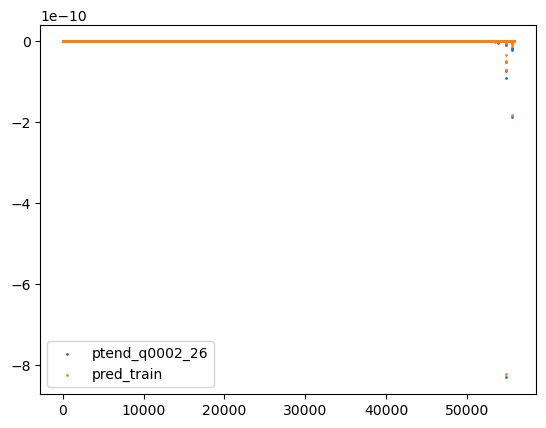

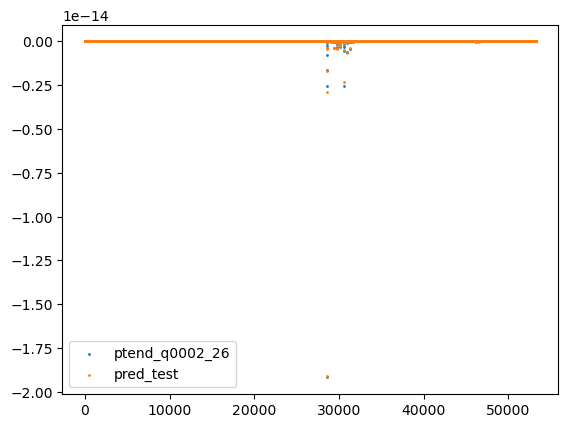

In [23]:
plt.scatter(x=range(train.shape[0]),y=train[f], s=1,label=f)
plt.scatter(x=range(train.shape[0]),y=predTrain, s=1,label='pred_train')
plt.legend()
plt.show()

plt.scatter(x=range(val.shape[0]),y=val[f], s=1,label=f)
plt.scatter(x=range(val.shape[0]),y=predVal, s=1,label='pred_test')
plt.legend()
plt.show()